<a href="https://colab.research.google.com/github/sunilkumarrudragada/Automatic_Ticket_Classification_Nlp/blob/master/Automatic_Ticket_Classification_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint

In [2]:
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# mount google drivw
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [4]:
# Opening JSON file
f = open('/content/drive/MyDrive/complaints-2021-05-14_08_16.json') # Write the path to your data file and load it

# returns JSON object as
# a dictionary
data = json.load(f)
df=pd.json_normalize(data)

In [5]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


## Data preparation

In [6]:
# Inspect the dataframe to understand the given data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [7]:
print(f'shape of dataframe {df.shape}')

shape of dataframe (78313, 22)


In [8]:
#print the column names
print(f'column Names: {df.columns.values}')

column Names: ['_index' '_type' '_id' '_score' '_source.tags' '_source.zip_code'
 '_source.complaint_id' '_source.issue' '_source.date_received'
 '_source.state' '_source.consumer_disputed' '_source.product'
 '_source.company_response' '_source.company' '_source.submitted_via'
 '_source.date_sent_to_company' '_source.company_public_response'
 '_source.sub_product' '_source.timely' '_source.complaint_what_happened'
 '_source.sub_issue' '_source.consumer_consent_provided']


In [9]:
print(f'length of columns: {len(df.columns.values)}')

length of columns: 22


In [10]:
#Assign new column names
df.columns=df.columns.str.replace(r'^_?(source\.)?', '', regex=True).values

In [11]:
print(f'column Names after renaming: {df.columns.values}')

column Names after renaming: ['index' 'type' 'id' 'score' 'tags' 'zip_code' 'complaint_id' 'issue'
 'date_received' 'state' 'consumer_disputed' 'product' 'company_response'
 'company' 'submitted_via' 'date_sent_to_company'
 'company_public_response' 'sub_product' 'timely'
 'complaint_what_happened' 'sub_issue' 'consumer_consent_provided']


In [12]:
print(f'length of columns after renaming to ensure no column is removed: {len(df.columns.values)}')

length of columns after renaming to ensure no column is removed: 22


In [13]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [14]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened']=df['complaint_what_happened'].replace(r'^\s*$', np.nan, regex=True)

In [15]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,NaN,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,NaN,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,NaN,Charged too much interest,N/A


In [16]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'], inplace=True)

In [17]:
print('shape of df after removing empty strings in complaint_what_happened', df.shape)

shape of df after removing empty strings in complaint_what_happened (21072, 22)


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [18]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
  text = text.lower() # lowercase
  text = re.sub('\[.*?\]', '', text) # Remove text in square brackets
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)# Remove punctuation
  text = re.sub('\w*\d\w*', '', text)# Remove words containing numbers
  return text

In [19]:
#Write your function to Lemmatize the texts
nlp=spacy.load('en_core_web_sm')
def lemmatize_texts(texts, batch_size=1000, n_process=4):
    """
    Lemmatizes a list of texts using spaCy's nlp.pipe for efficiency.

    Args:
        texts (list or pd.Series): List of text strings to lemmatize
        batch_size (int): Number of texts processed per batch
        n_process (int): Number of CPU processes to use

    Returns:
        list: Lemmatized texts as strings
    """
    results = []
    for doc in tqdm(nlp.pipe(texts, batch_size=batch_size, n_process=n_process), total=len(texts)):
        lemmas = [token.lemma_ for token in doc]
        results.append(" ".join(lemmas))
    return results

In [20]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
from tqdm import tqdm
tqdm.pandas()
df_clean = pd.DataFrame()

df_clean['complaints'] = df['complaint_what_happened']

df['cleaned_complaints'] = df['complaint_what_happened'].progress_apply(clean_text)

df_clean['lemmatized_complaints'] = lemmatize_texts(df['cleaned_complaints'].tolist())

100%|██████████| 21072/21072 [03:23<00:00, 103.70it/s]


In [21]:
df_clean.head()

,complaints,lemmatized_complaints
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase ba...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date...
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my id...",chase card be report on however fraudulent application have be submit my identity without my c...
11,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} t...",on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards t...
14,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my...,my grand son give I check for I deposit it into my chase account after fund clear my chase ban...


In [22]:
#Write your function to extract the POS tags

def pos_tag(text):
  # write your code here
  # text is an array
  results = []
  for doc in tqdm(nlp.pipe(text, batch_size=1000, n_process=4), total=len(text)):
    tokenText = [token.lemma_ for token in doc if token.tag_ == "NN"]
    results.append(" ".join(tokenText))
  return results



df_clean["complaint_POS_removed"] = pos_tag(df_clean['lemmatized_complaints']) #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


100%|██████████| 21072/21072 [03:21<00:00, 104.74it/s]


In [23]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaints,lemmatized_complaints,complaint_POS_removed
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase ba...,morning name stop service debt verification statement bank debt mail month debt right informatio...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date...,card agent anniversary date agent information order account anniversary date consent recording a...
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my id...",chase card be report on however fraudulent application have be submit my identity without my c...,chase card report application identity consent service credit identity applicant
11,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} t...",on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards t...,ticket offer ticket reward card information offer minute screen decision chase bank chase bank n...
14,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my...,my grand son give I check for I deposit it into my chase account after fund clear my chase ban...,son chase account fund chase bank account money son check money chase bank money son chase time ...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




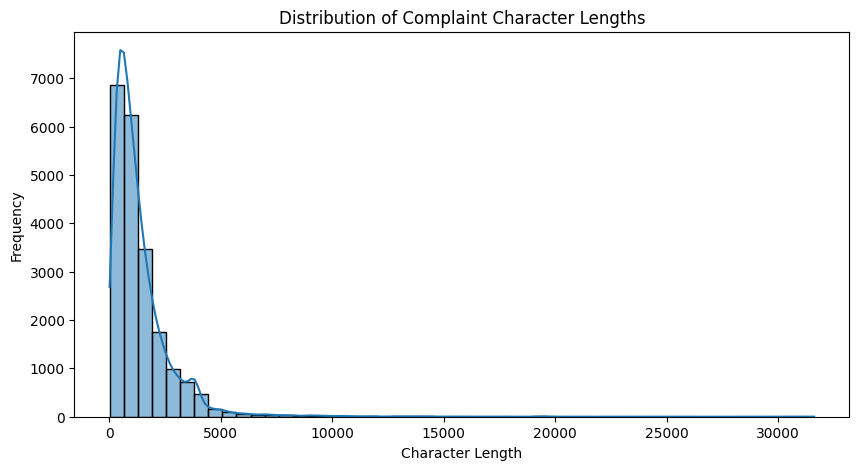

In [24]:
# Write your code here to visualise the data according to the 'Complaint' character length
# Calculate character length of each complaint
df_clean['complaint_length'] = df_clean['complaints'].str.len()

# histogram
plt.figure(figsize=(10,5))
sns.histplot(df_clean['complaint_length'], bins=50, edgecolor='black', kde=True)
plt.title("Distribution of Complaint Character Lengths")
plt.xlabel("Character Length")
plt.ylabel("Frequency")
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [25]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud
text=' '.join(df_clean['complaint_POS_removed'])
wordcloud = WordCloud(width=800, height=500, background_color='white', max_words=40).generate(text)

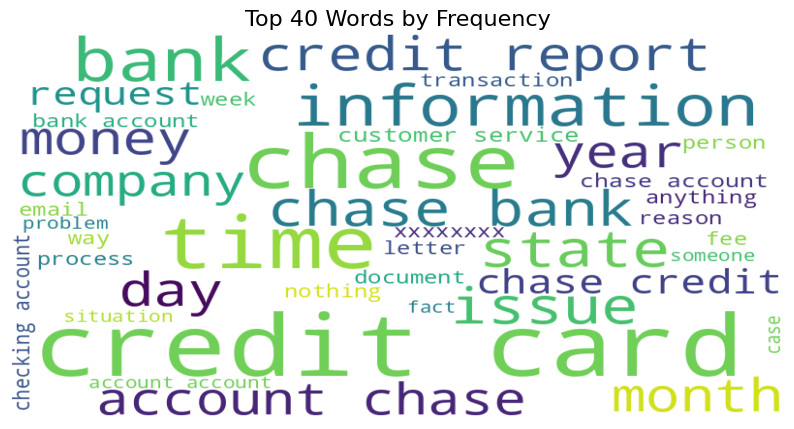

In [26]:
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear', aspect='auto')
plt.axis('off')
plt.title('Top 40 Words by Frequency', fontsize=16)
plt.show()

In [27]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [28]:
df_clean.head()

,complaints,lemmatized_complaints,complaint_POS_removed,complaint_length,Complaint_clean
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase ba...,morning name stop service debt verification statement bank debt mail month debt right informatio...,486,morning name stop service debt verification statement bank debt mail month debt right informatio...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date...,card agent anniversary date agent information order account anniversary date consent recording a...,355,card agent anniversary date agent information order account anniversary date consent recording a...
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my id...",chase card be report on however fraudulent application have be submit my identity without my c...,chase card report application identity consent service credit identity applicant,224,chase card report application identity consent service credit identity applicant
11,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} t...",on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards t...,ticket offer ticket reward card information offer minute screen decision chase bank chase bank n...,1502,ticket offer ticket reward card information offer minute screen decision chase bank chase bank n...
14,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my...,my grand son give I check for I deposit it into my chase account after fund clear my chase ban...,son chase account fund chase bank account money son check money chase bank money son chase time ...,477,son chase account fund chase bank account money son check money chase bank money son chase time ...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [29]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df_clean['complaints'])

In [30]:
words=vectorizer.get_feature_names_out()
frequency=X.toarray().sum(axis=0)
word_freq=pd.DataFrame({'word':words,'frequency':frequency})

top_30_unigrams = word_freq.sort_values(by='frequency', ascending=False).head(30)

print(top_30_unigrams)

              word  frequency
28923         xxxx     228998
5480         chase      80810
28920           xx      77015
1740       account      42745
7280        credit      32806
0               00      30482
5029          card      26941
3769          bank      26760
26256         told      16383
8415           did      16005
18799      payment      14123
4912        called      13474
20945     received      12876
26128         time      12223
16886        money      11990
22780         said      10891
15667         loan      10076
5559         check       9792
13947  information       9682
15417       letter       8462
23255         sent       8347
16992     mortgage       7980
18772          pay       7980
17693       number       7777
7633          days       7563
19150        phone       7528
3165         asked       7459
21819       report       7388
18807     payments       7243
3722       balance       7218


In [31]:
#Print the top 10 words in the unigram frequency
print(top_30_unigrams[: 10])

          word  frequency
28923     xxxx     228998
5480     chase      80810
28920       xx      77015
1740   account      42745
7280    credit      32806
0           00      30482
5029      card      26941
3769      bank      26760
26256     told      16383
8415       did      16005


In [32]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
vectorizer = CountVectorizer(stop_words='english', ngram_range=(2,2))
X = vectorizer.fit_transform(df_clean['complaints'])

words=vectorizer.get_feature_names_out()
frequency=X.toarray().sum(axis=0)
word_freq=pd.DataFrame({'word':words,'frequency':frequency})

top_30_bigrams = word_freq.sort_values( by='frequency', ascending=False).head(30)

print(top_30_bigrams)

                    word  frequency
788098         xxxx xxxx      90158
779760             xx xx      38193
779761           xx xxxx      28157
137980        chase bank      12725
195298       credit card      10947
788096           xxxx xx       5994
781508        xxxx chase       5132
112392      called chase       3699
145187  checking account       3568
196427     credit report       3248
201649  customer service       3021
142397        chase xxxx       2976
779677           xx 2020       2861
389214         jp morgan       2714
458454      morgan chase       2566
138595      chase credit       2392
3305             00 xxxx       2379
25087       account xxxx       2360
779660           xx 2019       2148
785877     xxxx received       2139
211139        debit card       1959
21967      account chase       1959
780441      xxxx account       1952
195307      credit cards       1895
779647           xx 2018       1862
781337       xxxx called       1809
180239   contacted chase    

In [33]:
#Print the top 10 words in the bigram frequency
print(top_30_bigrams[: 10])

                    word  frequency
788098         xxxx xxxx      90158
779760             xx xx      38193
779761           xx xxxx      28157
137980        chase bank      12725
195298       credit card      10947
788096           xxxx xx       5994
781508        xxxx chase       5132
112392      called chase       3699
145187  checking account       3568
196427     credit report       3248


In [34]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
vectorizer = CountVectorizer(stop_words='english', ngram_range=(3,3))
X = vectorizer.fit_transform(df_clean['complaints'])

words=vectorizer.get_feature_names_out()
frequency=X.toarray().sum(axis=0)
word_freq=pd.DataFrame({'word':words,'frequency':frequency})

top_30_trigrams = word_freq.sort_values( by='frequency', ascending=False).head(30)

print(top_30_trigrams)

                        word  frequency
1730340       xxxx xxxx xxxx      42037
1649186           xx xx xxxx      27747
1725204           xxxx xx xx       5987
1649107           xx xx 2020       2853
1652431         xx xxxx xxxx       2787
1652430           xx xxxx xx       2531
859878       jp morgan chase       2229
1649090           xx xx 2019       2127
1649082           xx xx 2018       1851
347713     chase credit card       1828
1730339         xxxx xxxx xx       1672
1726202      xxxx xxxx chase       1638
16823               00 xx xx       1477
1650031        xx xxxx chase       1298
376565       chase xxxx xxxx       1240
17378           00 xxxx xxxx       1158
1651621     xx xxxx received       1118
342071       chase bank xxxx       1005
95782          account xx xx        970
96386      account xxxx xxxx        947
375852           chase xx xx        906
225311        bank xxxx xxxx        877
1725286       xxxx xxxx 2016        843
508717           dated xx xx        831


In [35]:
#Print the top 10 words in the trigram
print(top_30_trigrams[: 10])

                      word  frequency
1730340     xxxx xxxx xxxx      42037
1649186         xx xx xxxx      27747
1725204         xxxx xx xx       5987
1649107         xx xx 2020       2853
1652431       xx xxxx xxxx       2787
1652430         xx xxxx xx       2531
859878     jp morgan chase       2229
1649090         xx xx 2019       2127
1649082         xx xx 2018       1851
347713   chase credit card       1828


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [36]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [37]:
#All masked texts has been removed
df_clean.head()

,complaints,lemmatized_complaints,complaint_POS_removed,complaint_length,Complaint_clean
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase ba...,morning name stop service debt verification statement bank debt mail month debt right informatio...,486,morning name stop service debt verification statement bank debt mail month debt right informatio...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date...,card agent anniversary date agent information order account anniversary date consent recording a...,355,card agent anniversary date agent information order account anniversary date consent recording a...
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my id...",chase card be report on however fraudulent application have be submit my identity without my c...,chase card report application identity consent service credit identity applicant,224,chase card report application identity consent service credit identity applicant
11,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} t...",on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards t...,ticket offer ticket reward card information offer minute screen decision chase bank chase bank n...,1502,ticket offer ticket reward card information offer minute screen decision chase bank chase bank n...
14,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my...,my grand son give I check for I deposit it into my chase account after fund clear my chase ban...,son chase account fund chase bank account money son check money chase bank money son chase time ...,477,son chase account fund chase bank account money son check money chase bank money son chase time ...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [38]:
#Write your code here to initialise the TfidfVectorizer

tf_idf_vectrorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [39]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tf_idf_vectrorizer.fit_transform(df_clean['Complaint_clean'])

print(f'shape of tf_idf_matrix {dtm.shape}')
doc_term_matrix_df = pd.DataFrame(dtm.toarray(), columns=tf_idf_vectrorizer.get_feature_names_out())
doc_term_matrix_df.index = df_clean.index
doc_term_matrix_df.head()

shape of tf_idf_matrix (21072, 6768)


aarp   ab  abandonment  abatement  abbreviation  abet  abide  ability  \
1    0.0  0.0          0.0        0.0           0.0   0.0    0.0      0.0   
2    0.0  0.0          0.0        0.0           0.0   0.0    0.0      0.0   
10   0.0  0.0          0.0        0.0           0.0   0.0    0.0      0.0   
11   0.0  0.0          0.0        0.0           0.0   0.0    0.0      0.0   
14   0.0  0.0          0.0        0.0           0.0   0.0    0.0      0.0   

    abovementione  abovereference  absence  absent  absolve  absurdity  \
1             0.0             0.0      0.0     0.0      0.0        0.0   
2             0.0             0.0      0.0     0.0      0.0        0.0   
10            0.0             0.0      0.0     0.0      0.0        0.0   
11            0.0             0.0      0.0     0.0      0.0        0.0   
14            0.0             0.0      0.0     0.0      0.0        0.0   

    abundance  abuse  abuser   ac  acc  acccount  acceleration  accent  \
1         0.0    0.0     0.0  0.0  0.0       0.0           0.0     0.0   
2         0.0    0.0     0.0  0.0  0.0       0.0           0.0     0.0   
10        0.0    0.0     0.0  0.0  0.0       0.0           0.0     0.0   
11        0.0    0.0     0.0  0.0  0.0       0.0           0.0     0.0   
14        0.0    0.0     0.0  0.0  0.0       0.0           0.0     0.0   

    accept  acceptance  access  accessibility  accessory  accident  \
1      0.0         0.0     0.0            0.0        0.0       0.0   
2      0.0         0.0     0.0            0.0        0.0       0.0   
10     0.0         0.0     0.0            0.0        0.0       0.0   
11     0.0         0.0     0.0            0.0        0.0       0.0   
14     0.0         0.0     0.0            0.0        0.0       0.0   

    accommodation  accomodation  accompany  accomplice  accont  accord  \
1             0.0           0.0        0.0         0.0     0.0     0.0   
2             0.0           0.0        0.0         0.0     0.0     0.0   
10            0.0           0.0        0.0         0.0     0.0     0.0   
11            0.0           0.0        0.0         0.0     0.0     0.0   
14            0.0           0.0        0.0         0.0     0.0     0.0   

    accordance  accou  accouint  accoun   account  accountability  accountand  \
1          0.0    0.0       0.0     0.0  0.088076             0.0         0.0   
2          0.0    0.0       0.0     0.0  0.067896             0.0         0.0   
10         0.0    0.0       0.0     0.0  0.000000             0.0         0.0   
11         0.0    0.0       0.0     0.0  0.118282             0.0         0.0   
14         0.0    0.0       0.0     0.0  0.135062             0.0         0.0   

    accountant  accountbalance  accountchase  accountfunde  accountholder  \
1          0.0             0.0           0.0           0.0            0.0   
2          0.0             0.0           0.0           0.0            0.0   
10         0.0             0.0           0.0           0.0            0.0   
11         0.0             0.0           0.0           0.0            0.0   
14         0.0             0.0           0.0           0.0            0.0   

    accounti  accounting  accountit  accountlevel  accountmy  accountone  \
1        0.0         0.0        0.0           0.0        0.0         0.0   
2        0.0         0.0        0.0           0.0        0.0         0.0   
10       0.0         0.0        0.0           0.0        0.0         0.0   
11       0.0         0.0        0.0           0.0        0.0         0.0   
14       0.0         0.0        0.0           0.0        0.0         0.0   

    accountplease  accountshe  accout  accredit  accrue  acct  accumulate  \
1             0.0         0.0     0.0       0.0     0.0   0.0         0.0   
2             0.0         0.0     0.0       0.0     0.0   0.0         0.0   
10            0.0         0.0     0.0       0.0     0.0   0.0         0.0   
11            0.0         0.0     0.0       0.0     0.0   0.0         

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [40]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [41]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)#write your code here

In [42]:
nmf_model.fit(dtm)
len(tf_idf_vectrorizer.get_feature_names_out())

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



6768

In [43]:
#Print the Top15 words for each of the topics
# Get the feature names
feature_names = tf_idf_vectrorizer.get_feature_names_out()

# Number of top words to display
top_n = 15

# Print top words for each topic
for index, topic in enumerate(nmf_model.components_):
    print(f"Top words for Topic #{index}:")
    top_words_indices = topic.argsort()[-top_n:]  # indices of top words
    top_words = [feature_names[i] for i in top_words_indices]
    print(",".join(top_words))
    print("\n")

Top words for Topic #0:
transfer,claim,business,number,transaction,checking,day,branch,deposit,fund,chase,money,bank,check,account


Top words for Topic #1:
company,statement,time,balance,merchant,fraud,service,purchase,transaction,fee,dispute,credit,chase,charge,card


Top words for Topic #2:
request,sale,house,foreclosure,rate,document,time,letter,year,property,modification,home,chase,mortgage,loan


Top words for Topic #3:
bureau,limit,identity,application,chase,reporting,information,debt,company,score,account,card,inquiry,report,credit


Top words for Topic #4:
error,mortgage,year,account,credit,date,chase,auto,time,day,statement,fee,month,balance,payment




In [44]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_values = nmf_model.transform(dtm)

In [45]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_values.argmax(axis=1) #write your code to assign topics to each rows.

In [46]:
df_clean.head()

,complaints,lemmatized_complaints,complaint_POS_removed,complaint_length,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase ba...,morning name stop service debt verification statement bank debt mail month debt right informatio...,486,morning name stop service debt verification statement bank debt mail month debt right informatio...,2
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date...,card agent anniversary date agent information order account anniversary date consent recording a...,355,card agent anniversary date agent information order account anniversary date consent recording a...,1
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my id...",chase card be report on however fraudulent application have be submit my identity without my c...,chase card report application identity consent service credit identity applicant,224,chase card report application identity consent service credit identity applicant,3
11,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} t...",on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards t...,ticket offer ticket reward card information offer minute screen decision chase bank chase bank n...,1502,ticket offer ticket reward card information offer minute screen decision chase bank chase bank n...,3
14,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my...,my grand son give I check for I deposit it into my chase account after fund clear my chase ban...,son chase account fund chase bank account money son check money chase bank money son chase time ...,477,son chase account fund chase bank account money son check money chase bank money son chase time ...,0


In [47]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

,complaints,lemmatized_complaints,complaint_POS_removed,complaint_length,Complaint_clean,Topic
17,With out notice J.P. Morgan Chase restricted my account by my debit card Tuesday XX/XX/2019. On ...,with out notice jp morgan chase restrict my account by my debit card tuesday on thursday I g...,notice account debit card branch customer service representative account branch fund deposit pla...,2277,notice account debit card branch customer service representative account branch fund deposit pla...,0
14,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my...,my grand son give I check for I deposit it into my chase account after fund clear my chase ban...,son chase account fund chase bank account money son check money chase bank money son chase time ...,477,son chase account fund chase bank account money son check money chase bank money son chase time ...,0
27,I opened an account with chase bank on XXXX and used a code for XXXX bonus. I called to follow u...,I open an account with chase bank on xxxx and use a code for xxxx bonus I call to follow up on x...,account bank code bonus term everything account deposit bonus day require deposit account coupon...,413,account bank code bonus term everything account deposit bonus day require deposit account coupon...,0
24,mishandling of this account by Chase auto and XXXX.,mishandle of this account by chase auto and xxxx,mishandle account auto,51,mishandle account auto,0
35,I opened the saving account for the {$25.00} bonus. I was supposed to received the {$25.00} bonu...,I open the save account for the bonus I be suppose to received the bonus after consecutive...,save account bonus bonus auto transfer check transfer fund checking account fund account request...,538,save account bonus bonus auto transfer check transfer fund checking account fund account request...,0
21,"On XXXX XX/XX/2019, I made a {$300.00} payment to an online retailer using Chase quick pay with ...",on xxxx I make a payment to an online retailer use chase quick pay with xxxx on the chase we...,payment retailer use chase pay chase website scam website confirmation product response inquiry ...,3541,payment retailer use chase pay chase website scam website confirmation product response inquiry ...,1
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date...,card agent anniversary date agent information order account anniversary date consent recording a...,355,card agent anniversary date agent information order account anniversary date consent recording a...,1
30,"To whom it may concern, Chase bank charged wrongly overdraft fees, I have alert of low balance o...",to whom it may concern chase bank charge wrongly overdraft fee I have alert of low balance or un...,concern charge overdraft fee alert balance unsuficent fee balance transaction chase order overdr...,566,concern charge overdraft fee alert balance unsuficent fee balance transaction chase order overdr...,1
32,My chase amazon card was declined for a catering order I had placed for my brothers funeral in t...,my chase amazon card be decline for a catering order I have place for my brother funeral in the ...,chase amazon card decline catering order place brother funeral amount chase noon today number ch...,1972,chase amazon card decline catering order place brother funeral amount chase noon today number ch...,1
40,"XXXX XXXX a sofa, love seat, table and chairs and was never delivered. Debit card charged {$2400...",xxxx xxxx a sofa love seat table and chair and be never deliver debit card charge bank say vis...,sofa love seat table chair debit card charge bank visa claim furniture money,165,sofa love seat table chair debit card charge bank visa claim furniture money,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [48]:
#Create the dictionary of Topic names and Topics

Topic_names = {
    0: 'Bank Account services',
    1: 'Theft/Dispute Reporting',
    2: 'Others',
    3: 'Credit card or prepaid card',
    4: 'Mortgage/Loan'
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

/tmp/ipython-input-48-3631620719.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [49]:
df_clean.head()

,complaints,lemmatized_complaints,complaint_POS_removed,complaint_length,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase ba...,morning name stop service debt verification statement bank debt mail month debt right informatio...,486,morning name stop service debt verification statement bank debt mail month debt right informatio...,Others
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date...,card agent anniversary date agent information order account anniversary date consent recording a...,355,card agent anniversary date agent information order account anniversary date consent recording a...,Theft/Dispute Reporting
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my id...",chase card be report on however fraudulent application have be submit my identity without my c...,chase card report application identity consent service credit identity applicant,224,chase card report application identity consent service credit identity applicant,Credit card or prepaid card
11,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} t...",on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards t...,ticket offer ticket reward card information offer minute screen decision chase bank chase bank n...,1502,ticket offer ticket reward card information offer minute screen decision chase bank chase bank n...,Credit card or prepaid card
14,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my...,my grand son give I check for I deposit it into my chase account after fund clear my chase ban...,son chase account fund chase bank account money son check money chase bank money son chase time ...,477,son chase account fund chase bank account money son check money chase bank money son chase time ...,Bank Account services


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [50]:
#Create the dictionary again of Topic names and Topics

Topic_names = {
    'Bank Account services': 0,
    'Theft/Dispute Reporting': 1,
    'Others': 2,
    'Credit card or prepaid card': 3,
    'Mortgage/Loan': 4
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

/tmp/ipython-input-50-1973470646.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [51]:
df_clean.head()

,complaints,lemmatized_complaints,complaint_POS_removed,complaint_length,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase ba...,morning name stop service debt verification statement bank debt mail month debt right informatio...,486,morning name stop service debt verification statement bank debt mail month debt right informatio...,2
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date...,card agent anniversary date agent information order account anniversary date consent recording a...,355,card agent anniversary date agent information order account anniversary date consent recording a...,1
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my id...",chase card be report on however fraudulent application have be submit my identity without my c...,chase card report application identity consent service credit identity applicant,224,chase card report application identity consent service credit identity applicant,3
11,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} t...",on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards t...,ticket offer ticket reward card information offer minute screen decision chase bank chase bank n...,1502,ticket offer ticket reward card information offer minute screen decision chase bank chase bank n...,3
14,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my...,my grand son give I check for I deposit it into my chase account after fund clear my chase ban...,son chase account fund chase bank account money son check money chase bank money son chase time ...,477,son chase account fund chase bank account money son check money chase bank money son chase time ...,0


In [52]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data

# Changed the complaint_what_happened to complaints in above cell
training_data=df_clean[['complaints', 'Topic']]

In [53]:
training_data.head()

,complaints,Topic
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...,2
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,1
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my id...",3
11,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} t...",3
14,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my...,0


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [54]:

#Write your code to get the Vector count
count_vect=CountVectorizer()
X_train_counts=count_vect.fit_transform(training_data['complaints'])


#Write your code here to transform the word vector to tf-idf
tfidf_transformer=TfidfTransformer()
X_train_tf=tfidf_transformer.fit_transform(X_train_counts)

In [55]:
px.bar(x=training_data['Topic'].value_counts().index, y=training_data['Topic'].value_counts().values/max(training_data['Topic'].value_counts().values), title='Class Imbalance')

In [56]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    training_data['complaints'], training_data['Topic'],
    test_size=0.2, random_state=42,
    stratify=training_data['Topic']
)

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [57]:
# Write your code here to build any 3 models and evaluate them using the required metrics


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Logistic Regression:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 score:", f1_score(y_test, y_pred, average='weighted'))


Logistic Regression:
Accuracy: 0.6
Precision: 0.4666666666666667
Recall: 0.6
F1 score: 0.5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [58]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 score:", f1_score(y_test, y_pred, average='weighted'))

Accuracy: 0.6
Precision: 0.4666666666666666
Recall: 0.6
F1 score: 0.5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [59]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 score:", f1_score(y_test, y_pred, average='weighted'))

Accuracy: 0.6


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Precision: 0.4666666666666667
Recall: 0.6
F1 score: 0.5
